In [208]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [209]:
df = pd.read_csv("digital_marketing_campaign_dataset.csv")

# Feature Engineering
## 1. Xóa những cột không cần thiết

In [210]:

col_drop = ['CustomerID', 'AdvertisingPlatform', 'AdvertisingTool']

for col in df:
    if col in col_drop:
        df=df.drop(columns = col) 
    
df.columns 

Index(['Age', 'Gender', 'Income', 'CampaignChannel', 'CampaignType', 'AdSpend',
       'ClickThroughRate', 'ConversionRate', 'WebsiteVisits', 'PagesPerVisit',
       'TimeOnSite', 'SocialShares', 'EmailOpens', 'EmailClicks',
       'PreviousPurchases', 'LoyaltyPoints', 'Conversion'],
      dtype='object')

## 2. Mã hóa biến phân loại


In [211]:

from sklearn.preprocessing import OneHotEncoder

cate_col = ['CampaignChannel', 'CampaignType']
encod = OneHotEncoder(sparse_output=False) 
encoded_data = encod.fit_transform(df[cate_col])
feature_names = encod.get_feature_names_out(cate_col)
encoded_df = pd.DataFrame(encoded_data, columns=feature_names)

df['CampaignType_encoded'] = encoded_df[
    [col for col in encoded_df.columns if 'CampaignType' in col]
    ].astype(int).astype(str).agg(''.join, axis=1).astype(int)

df['CampaignChannel_encoded'] = encoded_df[
    [col for col in encoded_df.columns if 'CampaignChannel' in col]
    ].astype(int).astype(str).agg(''.join, axis=1).astype(int)



In [212]:
# tạo từ điển lưu trữ kết quả mã hóa
mapping_dict={}

# Lưu ánh xạ cho mỗi cột 
for col in cate_col:
    # Lấy giá trị phân loại ban đầu 
    values=df[col].unique()
    # lấy chuỗi mã hóa tương ứng
    encoded_values=df[col + '_encoded'].unique()
    # ánh xạ 
    mapping_dict[col]={original: encoded for original, encoded in zip(values, encoded_values)}
    

# Xóa các cột phân loại ban đầu 
df=df.drop(columns = cate_col )

print(mapping_dict)

{'CampaignChannel': {'Social Media': np.int64(1), 'Email': np.int64(10000), 'PPC': np.int64(1000), 'Referral': np.int64(100), 'SEO': np.int64(10)}, 'CampaignType': {'Awareness': np.int64(1000), 'Retention': np.int64(1), 'Conversion': np.int64(10), 'Consideration': np.int64(100)}}


In [213]:

df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0}).astype(int)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18260\2429311090.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Gender'] = df['Gender'].replace({'Male': 1, 'Female': 0}).astype(int)


# Huấn luyện mô hình

In [214]:
# Chia dữ liệu thành các biến độc lập và phụ thuộc 
X=df.drop('Conversion', axis=1)
y= df['Conversion']

In [215]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()}

results = {name: {'train_accuracies': [], 'train_precisions': [], 'train_recalls': [], 'train_f1_scores': [], 
                  'train_auc_scores': [], 'test_accuracies': [], 'test_precisions': [], 
                  'test_recalls': [], 'test_f1_scores': [], 'test_auc_scores': [],'test_confusion_matrices': [],
                  'all_y_true': [], 'all_y_pred': [], 'all_y_proba': []} for name in models}

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for name, model in models.items():
        model.fit(X_train, y_train)
    
        # Đánh giá trên tập kiểm tra
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]
        
        results[name]["all_y_true"].extend(y_test)
        results[name]["all_y_pred"].extend(y_test_pred)
        results[name]["all_y_proba"].extend(y_test_proba)
        
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, average='binary')  
        test_recall = recall_score(y_test, y_test_pred, average='binary') 
        test_f1 = f1_score(y_test, y_test_pred, average='binary')
        cm = confusion_matrix(y_test, y_test_pred) 
        test_auc = roc_auc_score(y_test, y_test_proba)

        results[name]["test_accuracies"].append(test_accuracy)
        results[name]["test_precisions"].append(test_precision)
        results[name]["test_recalls"].append(test_recall)
        results[name]["test_f1_scores"].append(test_f1)
        results[name]["test_confusion_matrices"].append(cm)
        results[name]["test_auc_scores"].append(test_auc)
        
        # Đánh giá trên tập huấn luyện
        y_train_pred = model.predict(X_train)
        y_train_proba = model.predict_proba(X_train)[:, 1]

        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred, average='binary')  
        train_recall = recall_score(y_train, y_train_pred, average='binary') 
        train_f1 = f1_score(y_train, y_train_pred, average='binary') 
        train_auc = roc_auc_score(y_train, y_train_proba)

        results[name]["train_accuracies"].append(train_accuracy)
        results[name]["train_precisions"].append(train_precision)
        results[name]["train_recalls"].append(train_recall)
        results[name]["train_f1_scores"].append(train_f1)
        results[name]["train_auc_scores"].append(train_auc)



C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 6310, number of negative: 890
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876389 -> initscore=1.958669
[LightGBM] [Info] Start training from score 1.958669


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 6310, number of negative: 890
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876389 -> initscore=1.958669
[LightGBM] [Info] Start training from score 1.958669


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 6311, number of negative: 889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876528 -> initscore=1.959952
[LightGBM] [Info] Start training from score 1.959952


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 6311, number of negative: 889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876528 -> initscore=1.959952
[LightGBM] [Info] Start training from score 1.959952


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 6311, number of negative: 889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876528 -> initscore=1.959952
[LightGBM] [Info] Start training from score 1.959952


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 6311, number of negative: 889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876528 -> initscore=1.959952
[LightGBM] [Info] Start training from score 1.959952


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 6311, number of negative: 889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876528 -> initscore=1.959952
[LightGBM] [Info] Start training from score 1.959952


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 6311, number of negative: 889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876528 -> initscore=1.959952
[LightGBM] [Info] Start training from score 1.959952


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 6311, number of negative: 889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876528 -> initscore=1.959952
[LightGBM] [Info] Start training from score 1.959952


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 6311, number of negative: 889
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2041
[LightGBM] [Info] Number of data points in the train set: 7200, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.876528 -> initscore=1.959952
[LightGBM] [Info] Start training from score 1.959952


In [216]:
# Tính trung bình cho từng mô hình
for name in models: 
    mean_train_accuracy = np.mean(results[name]["train_accuracies"])
    mean_train_precision = np.mean(results[name]["train_precisions"])
    mean_train_recall = np.mean(results[name]["train_recalls"])
    mean_train_f1 = np.mean(results[name]["train_f1_scores"])
    mean_train_auc = np.mean(results[name]["train_auc_scores"])

    mean_test_accuracy = np.mean(results[name]["test_accuracies"])
    mean_test_precision = np.mean(results[name]["test_precisions"])
    mean_test_recall = np.mean(results[name]["test_recalls"])
    mean_test_f1 = np.mean(results[name]["test_f1_scores"])
    total_confusion_matrix = sum(results[name]["test_confusion_matrices"])
    mean_test_auc = np.mean(results[name]["test_auc_scores"])
    final_classification_report = classification_report(results[name]["all_y_true"],
                                                        results[name]["all_y_pred"], 
                                                        target_names=['Class 0', 'Class 1'])

    print(f'\nModel: {name}')
    print("Training Set Metrics:")
    print(f'- Mean Train Accuracy: {mean_train_accuracy:.2f}')
    print(f'- Mean Train Precision: {mean_train_precision:.2f}')
    print(f'- Mean Train Recall: {mean_train_recall:.2f}')
    print(f'- Mean Train F1 Score: {mean_train_f1:.2f}')
    print(f'- Mean Train AUC: {mean_train_auc:.2f}')
    
    print("\nTest Set Metrics:")
    print(f'- Mean Test Accuracy: {mean_test_accuracy:.2f}')
    print(f'- Mean Test Precision: {mean_test_precision:.2f}')
    print(f'- Mean Test Recall: {mean_test_recall:.2f}')
    print(f'- Mean Test F1 Score: {mean_test_f1:.2f}')
    print(f'- Mean Test AUC: {mean_test_auc:.2f}')
    print(final_classification_report)


Model: Decision Tree
Training Set Metrics:
- Mean Train Accuracy: 1.00
- Mean Train Precision: 1.00
- Mean Train Recall: 1.00
- Mean Train F1 Score: 1.00
- Mean Train AUC: 1.00

Test Set Metrics:
- Mean Test Accuracy: 0.83
- Mean Test Precision: 0.91
- Mean Test Recall: 0.90
- Mean Test F1 Score: 0.90
- Mean Test AUC: 0.63
              precision    recall  f1-score   support

     Class 0       0.33      0.36      0.34       988
     Class 1       0.91      0.90      0.90      7012

    accuracy                           0.83      8000
   macro avg       0.62      0.63      0.62      8000
weighted avg       0.84      0.83      0.83      8000


Model: Random Forest
Training Set Metrics:
- Mean Train Accuracy: 1.00
- Mean Train Precision: 1.00
- Mean Train Recall: 1.00
- Mean Train F1 Score: 1.00
- Mean Train AUC: 1.00

Test Set Metrics:
- Mean Test Accuracy: 0.90
- Mean Test Precision: 0.90
- Mean Test Recall: 1.00
- Mean Test F1 Score: 0.94
- Mean Test AUC: 0.82
              precisi

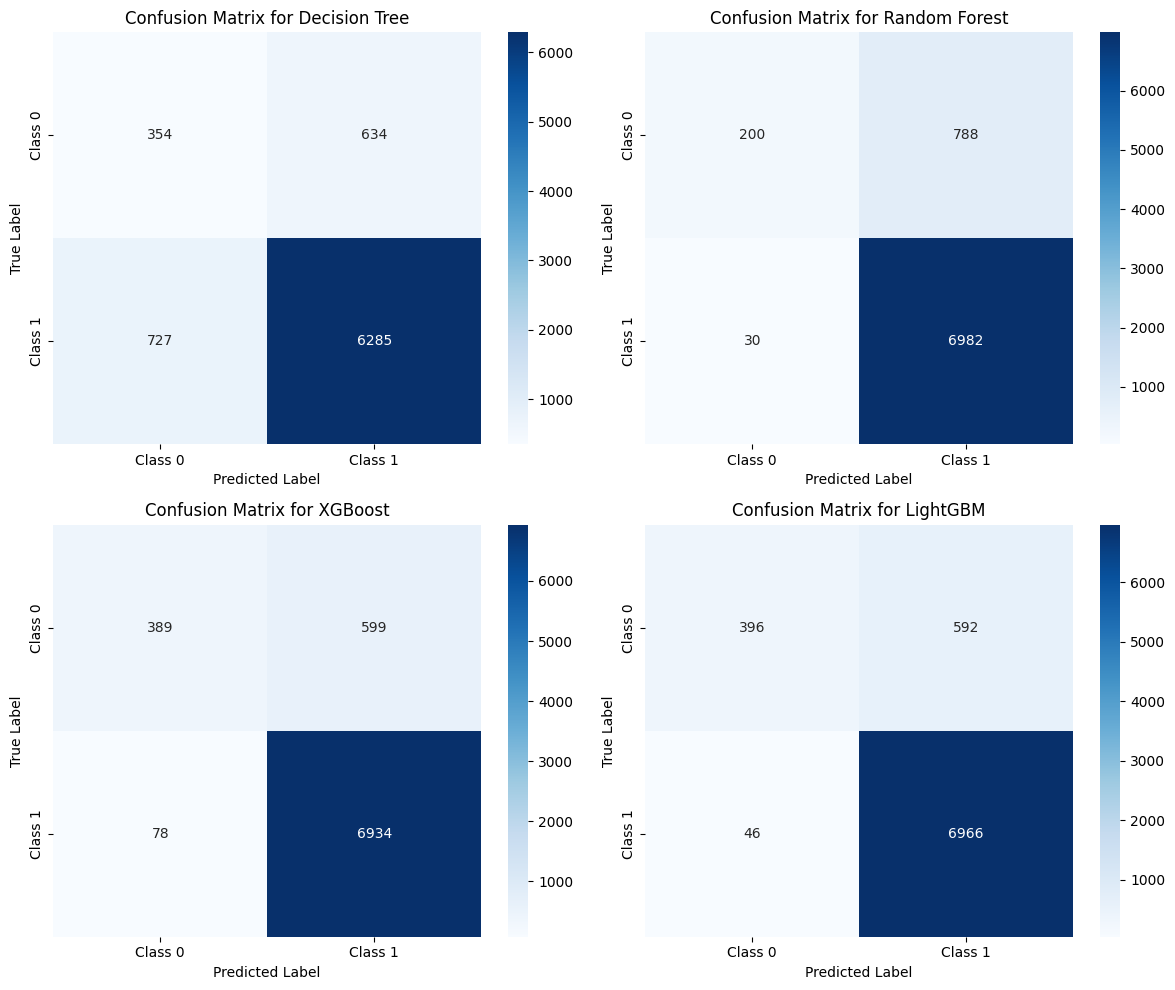

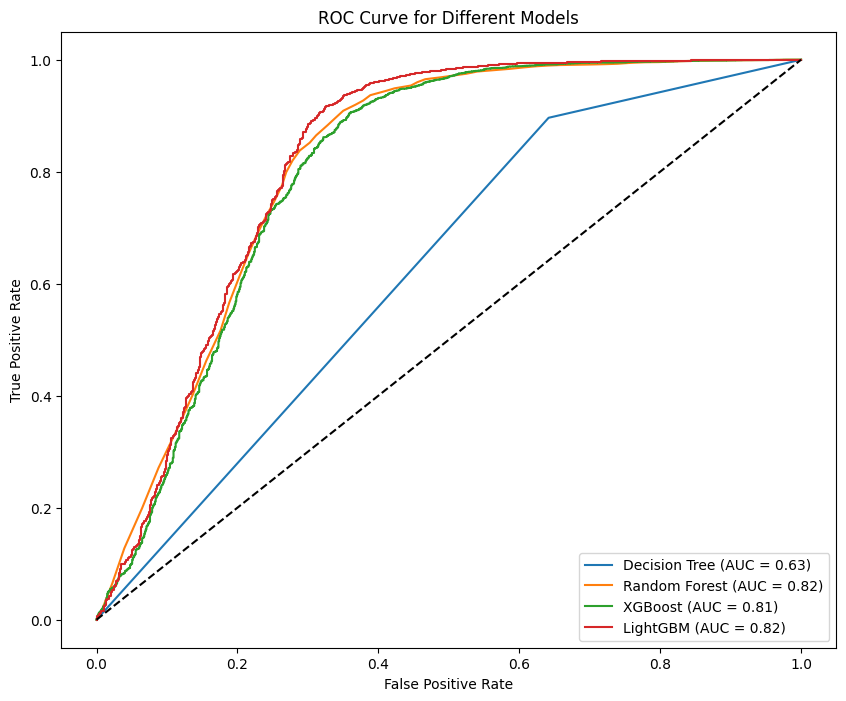

In [217]:
# Vẽ ma trận nhàm lẫn
plt.figure(figsize=(12, 10))

for i, name in enumerate(models, start=1):
    total_confusion_matrix = sum(results[name]["test_confusion_matrices"])  

    plt.subplot(2, 2, i)  
    sns.heatmap(total_confusion_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show() 

# Vẽ ROC và AUC cho từng mô hình
plt.figure(figsize=(10, 8))
for name in models:
    fpr, tpr, _ = roc_curve(results[name]["all_y_true"], results[name]["all_y_proba"])
    auc_score = roc_auc_score(results[name]["all_y_true"], results[name]["all_y_proba"])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Đường chéo y = x
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc='lower right')
plt.show()


# Huấn luyện lại mô hình với thuật toán SMOTEENN

In [218]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
smote_enn = SMOTEENN(random_state=42)
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier()}

results = {name: {'train_accuracies': [], 'train_precisions': [], 'train_recalls': [], 'train_f1_scores': [], 
                  'train_auc_scores': [], 'test_accuracies': [], 'test_precisions': [], 
                  'test_recalls': [], 'test_f1_scores': [], 'test_auc_scores': [],'test_confusion_matrices': [],
                  'all_y_true': [], 'all_y_pred': [], 'all_y_proba': []} for name in models}
feature_importances ={name: np.zeros(X.shape[1]) for name in models}

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)
    print(Counter(y_train))
    print(Counter(y_resampled))
    
    for name, model in models.items():
        model.fit(X_resampled, y_resampled)
    
        # Đánh giá trên tập kiểm tra
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]
        
        results[name]["all_y_true"].extend(y_test)
        results[name]["all_y_pred"].extend(y_test_pred)
        results[name]["all_y_proba"].extend(y_test_proba)
        
        test_accuracy = accuracy_score(y_test, y_test_pred)
        test_precision = precision_score(y_test, y_test_pred, average='binary')  
        test_recall = recall_score(y_test, y_test_pred, average='binary') 
        test_f1 = f1_score(y_test, y_test_pred, average='binary') 
        cm = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
        test_auc = roc_auc_score(y_test, y_test_proba)

        results[name]["test_accuracies"].append(test_accuracy)
        results[name]["test_precisions"].append(test_precision)
        results[name]["test_recalls"].append(test_recall)
        results[name]["test_f1_scores"].append(test_f1)
        results[name]["test_confusion_matrices"].append(cm)
        results[name]["test_auc_scores"].append(test_auc)
        
        # Đánh giá trên tập huấn luyện
        y_train_pred = model.predict(X_train)
        y_train_proba = model.predict_proba(X_train)[:, 1]

        train_accuracy = accuracy_score(y_train, y_train_pred)
        train_precision = precision_score(y_train, y_train_pred, average='binary')  
        train_recall = recall_score(y_train, y_train_pred, average='binary') 
        train_f1 = f1_score(y_train, y_train_pred, average='binary') 
        train_auc = roc_auc_score(y_train, y_train_proba)

        results[name]["train_accuracies"].append(train_accuracy)
        results[name]["train_precisions"].append(train_precision)
        results[name]["train_recalls"].append(train_recall)
        results[name]["train_f1_scores"].append(train_f1)
        results[name]["train_auc_scores"].append(train_auc)
        
        if hasattr(model, 'feature_importances_'):
            feature_importances[name] += model.feature_importances_


Counter({1: 6310, 0: 890})
Counter({0: 5003, 1: 3308})


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3308, number of negative: 5003
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000546 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 8311, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398027 -> initscore=-0.413694
[LightGBM] [Info] Start training from score -0.413694
Counter({1: 6310, 0: 890})
Counter({0: 5060, 1: 3329})


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3329, number of negative: 5060
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 8389, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.396829 -> initscore=-0.418695
[LightGBM] [Info] Start training from score -0.418695
Counter({1: 6311, 0: 889})
Counter({0: 5068, 1: 3317})


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3317, number of negative: 5068
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 8385, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395587 -> initscore=-0.423886
[LightGBM] [Info] Start training from score -0.423886
Counter({1: 6311, 0: 889})
Counter({0: 4975, 1: 3283})


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3283, number of negative: 4975
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Number of data points in the train set: 8258, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397554 -> initscore=-0.415668
[LightGBM] [Info] Start training from score -0.415668
Counter({1: 6311, 0: 889})
Counter({0: 5042, 1: 3349})


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3349, number of negative: 5042
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 8391, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.399118 -> initscore=-0.409141
[LightGBM] [Info] Start training from score -0.409141
Counter({1: 6311, 0: 889})
Counter({0: 5053, 1: 3304})


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3304, number of negative: 5053
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2539
[LightGBM] [Info] Number of data points in the train set: 8357, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395357 -> initscore=-0.424848
[LightGBM] [Info] Start training from score -0.424848
Counter({1: 6311, 0: 889})
Counter({0: 5031, 1: 3291})


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3291, number of negative: 5031
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 8322, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.395458 -> initscore=-0.424427
[LightGBM] [Info] Start training from score -0.424427
Counter({1: 6311, 0: 889})
Counter({0: 5094, 1: 3353})


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:30:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3353, number of negative: 5094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2540
[LightGBM] [Info] Number of data points in the train set: 8447, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.396946 -> initscore=-0.418208
[LightGBM] [Info] Start training from score -0.418208
Counter({1: 6311, 0: 889})
Counter({0: 5038, 1: 3330})


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:31:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3330, number of negative: 5038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 8368, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.397945 -> initscore=-0.414037
[LightGBM] [Info] Start training from score -0.414037
Counter({1: 6311, 0: 889})
Counter({0: 5059, 1: 3346})


C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\xgboost\core.py:158: UserWarning: [07:31:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 3346, number of negative: 5059
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 8405, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.398096 -> initscore=-0.413403
[LightGBM] [Info] Start training from score -0.413403


In [219]:
# Tính trung bình cho từng mô hình
for name in models: 
    mean_train_accuracy = np.mean(results[name]["train_accuracies"])
    mean_train_precision = np.mean(results[name]["train_precisions"])
    mean_train_recall = np.mean(results[name]["train_recalls"])
    mean_train_f1 = np.mean(results[name]["train_f1_scores"])
    mean_train_auc = np.mean(results[name]["train_auc_scores"])

    mean_test_accuracy = np.mean(results[name]["test_accuracies"])
    mean_test_precision = np.mean(results[name]["test_precisions"])
    mean_test_recall = np.mean(results[name]["test_recalls"])
    mean_test_f1 = np.mean(results[name]["test_f1_scores"])
    total_confusion_matrix = sum(results[name]["test_confusion_matrices"])
    mean_test_auc = np.mean(results[name]["test_auc_scores"])
    final_classification_report = classification_report(results[name]["all_y_true"], 
                                                        results[name]["all_y_pred"], 
                                                        target_names=['Class 0', 'Class 1'])

    print(f'\nModel: {name}')
    print("Training Set Metrics:")
    print(f'- Mean Train Accuracy: {mean_train_accuracy:.2f}')
    print(f'- Mean Train Precision: {mean_train_precision:.2f}')
    print(f'- Mean Train Recall: {mean_train_recall:.2f}')
    print(f'- Mean Train F1 Score: {mean_train_f1:.2f}')
    print(f'- Mean Train AUC: {mean_train_auc:.2f}')
    
    print("\nTest Set Metrics:")
    print(f'- Mean Test Accuracy: {mean_test_accuracy:.2f}')
    print(f'- Mean Test Precision: {mean_test_precision:.2f}')
    print(f'- Mean Test Recall: {mean_test_recall:.2f}')
    print(f'- Mean Test F1 Score: {mean_test_f1:.2f}')
    print(f'- Mean Test AUC: {mean_test_auc:.2f}')
    print(final_classification_report)


Model: Decision Tree
Training Set Metrics:
- Mean Train Accuracy: 0.88
- Mean Train Precision: 0.98
- Mean Train Recall: 0.88
- Mean Train F1 Score: 0.93
- Mean Train AUC: 0.88

Test Set Metrics:
- Mean Test Accuracy: 0.74
- Mean Test Precision: 0.91
- Mean Test Recall: 0.78
- Mean Test F1 Score: 0.84
- Mean Test AUC: 0.61
              precision    recall  f1-score   support

     Class 0       0.22      0.44      0.30       988
     Class 1       0.91      0.78      0.84      7012

    accuracy                           0.74      8000
   macro avg       0.56      0.61      0.57      8000
weighted avg       0.82      0.74      0.77      8000


Model: Random Forest
Training Set Metrics:
- Mean Train Accuracy: 0.92
- Mean Train Precision: 0.98
- Mean Train Recall: 0.92
- Mean Train F1 Score: 0.95
- Mean Train AUC: 0.96

Test Set Metrics:
- Mean Test Accuracy: 0.83
- Mean Test Precision: 0.92
- Mean Test Recall: 0.88
- Mean Test F1 Score: 0.90
- Mean Test AUC: 0.75
              precisi

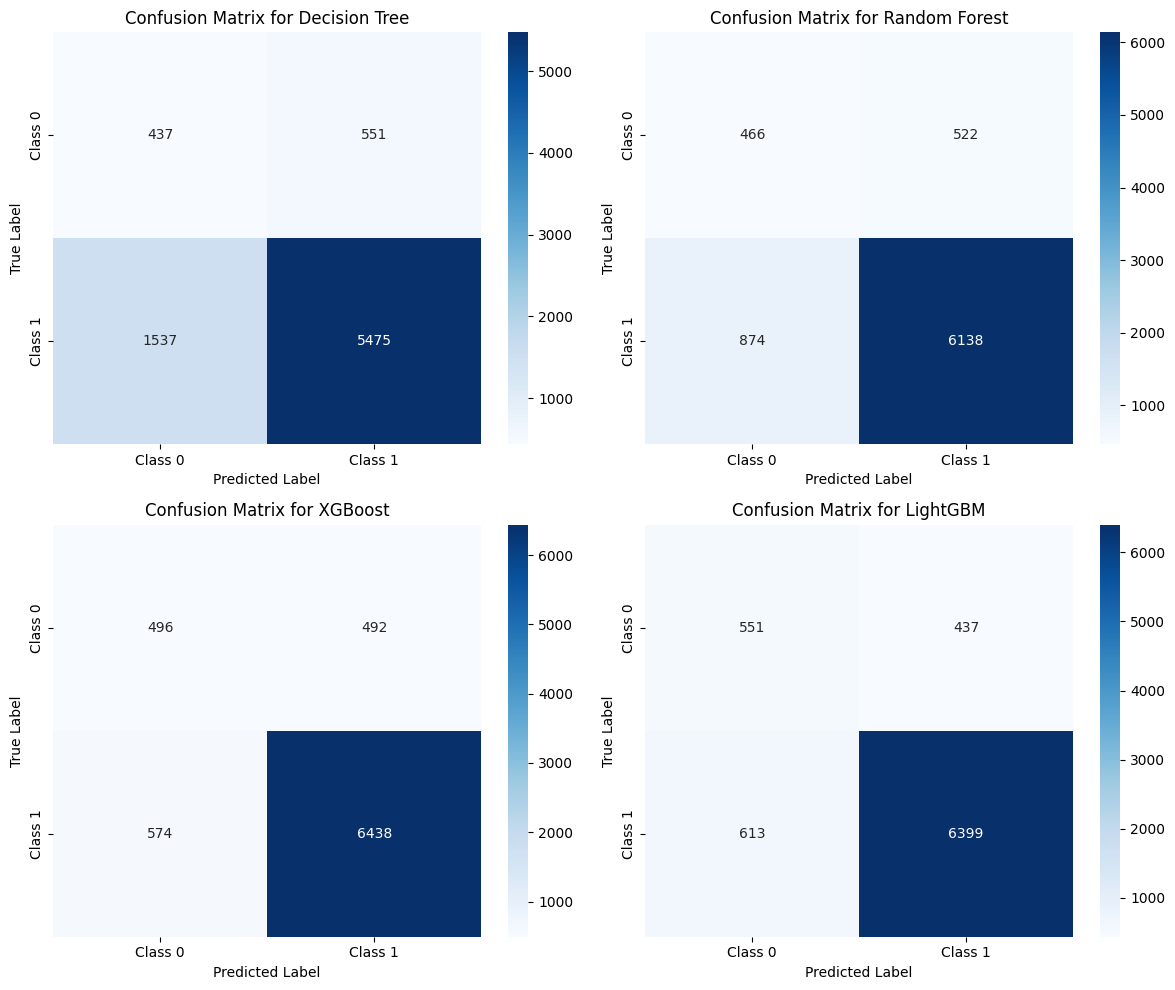

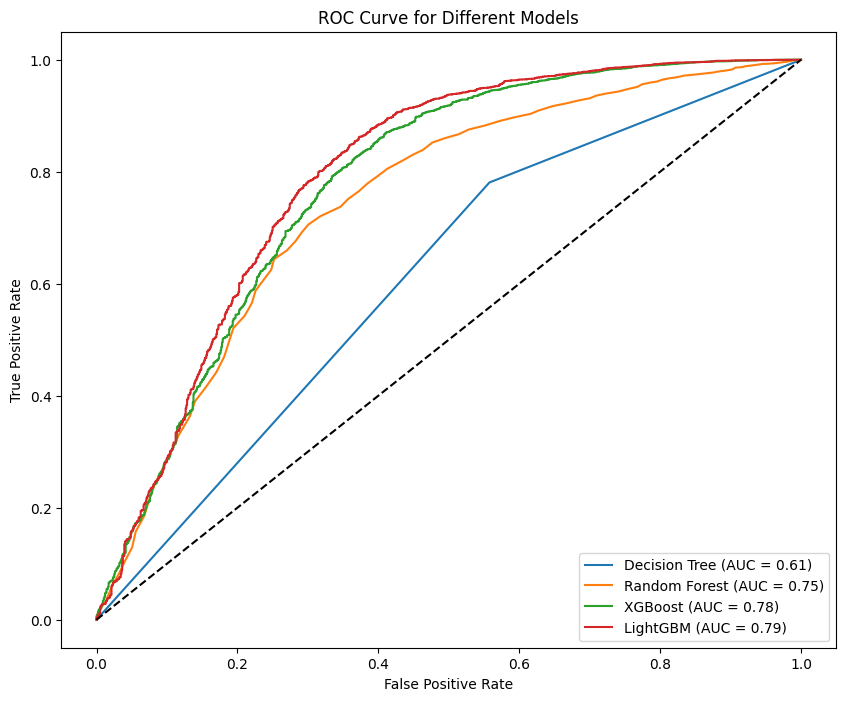

In [220]:
# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(12, 10))

for i, name in enumerate(models, start=1):
    total_confusion_matrix = sum(results[name]["test_confusion_matrices"])  

    plt.subplot(2, 2, i)  
    sns.heatmap(total_confusion_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show() 

# Vẽ ROC và AUC cho từng mô hình
plt.figure(figsize=(10, 8))
for name in models:
    fpr, tpr, _ = roc_curve(results[name]["all_y_true"], results[name]["all_y_proba"])
    auc_score = roc_auc_score(results[name]["all_y_true"], results[name]["all_y_proba"])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Đường chéo y = x
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc='lower right')
plt.show()


In [221]:
feature_importances_dfs = {}
for name in models:
    if np.sum(feature_importances[name]) > 0: 
        feature_importances[name] /= kf.n_splits  

        feature_importance_df = pd.DataFrame({'Feature': X.columns, 
                                              'Importance': feature_importances[name]})
        
        feature_importance_df = feature_importance_df.sort_values(by='Importance', 
                                                                  ascending=False)
        
        feature_importances_dfs[name] = feature_importance_df
        
        print(f"\nFeature Importance for {name}:")
        print(feature_importance_df)
        


Feature Importance for Decision Tree:
                    Feature  Importance
14     CampaignType_encoded    0.339965
3                   AdSpend    0.153549
13            LoyaltyPoints    0.062617
2                    Income    0.052755
8                TimeOnSite    0.052095
4          ClickThroughRate    0.044258
10               EmailOpens    0.040996
11              EmailClicks    0.039403
7             PagesPerVisit    0.036494
12        PreviousPurchases    0.035362
5            ConversionRate    0.033398
6             WebsiteVisits    0.032938
9              SocialShares    0.024143
0                       Age    0.023937
15  CampaignChannel_encoded    0.019455
1                    Gender    0.008635

Feature Importance for Random Forest:
                    Feature  Importance
14     CampaignType_encoded    0.162513
3                   AdSpend    0.133374
13            LoyaltyPoints    0.073389
11              EmailClicks    0.065407
8                TimeOnSite    0.064968
4 

## Top 5 đặc trưng quan trọng của mỗi mô hình

In [222]:

# Chọn đặc trưng quan trọng
selected_features = {}  

top_n_features = 5

for name in models:
    feature_importance_df = feature_importances_dfs[name]
    
    top_features = feature_importance_df.head(top_n_features)
    
    selected_features[name] = top_features['Feature'].values
    
    print(f"\nSelected Top {top_n_features} Features for {name}:")
    for _, row in top_features.iterrows():
        print(f"{row['Feature']}: {row['Importance']:.4f}")


Selected Top 5 Features for Decision Tree:
CampaignType_encoded: 0.3400
AdSpend: 0.1535
LoyaltyPoints: 0.0626
Income: 0.0528
TimeOnSite: 0.0521

Selected Top 5 Features for Random Forest:
CampaignType_encoded: 0.1625
AdSpend: 0.1334
LoyaltyPoints: 0.0734
EmailClicks: 0.0654
TimeOnSite: 0.0650

Selected Top 5 Features for XGBoost:
CampaignType_encoded: 0.3382
Gender: 0.1083
CampaignChannel_encoded: 0.0893
AdSpend: 0.0749
EmailClicks: 0.0570

Selected Top 5 Features for LightGBM:
Income: 309.1000
AdSpend: 281.9000
LoyaltyPoints: 258.0000
CampaignType_encoded: 244.3000
CampaignChannel_encoded: 216.2000


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18260\3650792035.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance', data=top_features_df, palette= colors)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18260\3650792035.py:12: UserWarning: 
The palette list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Feature', y='Importance', data=top_features_df, palette= colors)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18260\3650792035.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Feature', y='Importance', data=top_features_df, palette= colors)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18260\365

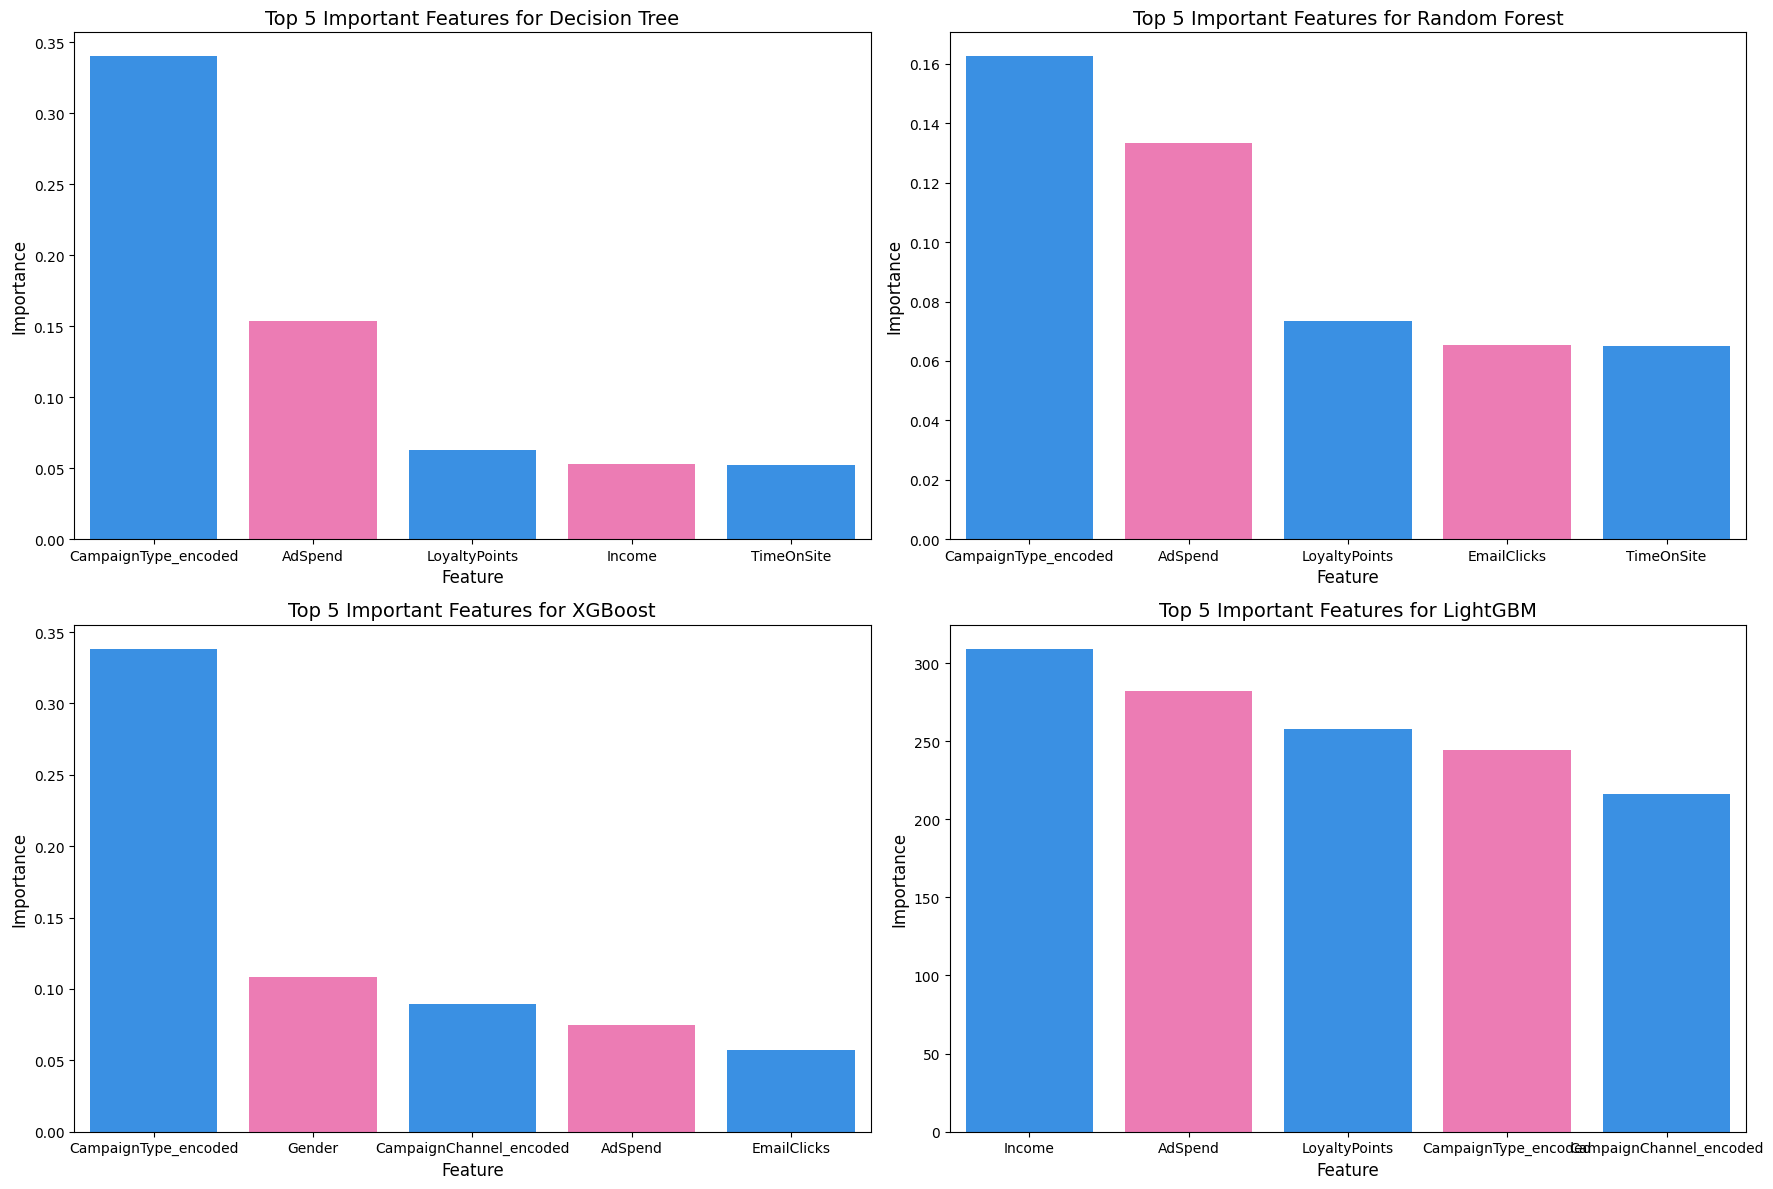

In [223]:
# Vẽ biểu đồ cho các đặc trưng quan trọng mỗi mô hình
plt.figure(figsize=(18, 12))

colors = ['#1E90FF', '#FF69B4']

for i, (name, features) in enumerate(selected_features.items(), 1):
    feature_importance_df = feature_importances_dfs[name]
    
    top_features_df = feature_importance_df[feature_importance_df['Feature'].isin(features)]
    
    plt.subplot(2, 2, i)
    sns.barplot(x='Feature', y='Importance', data=top_features_df, palette= colors)
    
    plt.title(f'Top {top_n_features} Important Features for {name}', fontsize=14)
    plt.xlabel('Feature', fontsize=12)
    plt.ylabel('Importance', fontsize=12)

plt.tight_layout()
plt.show()